# Dynamic Case Preparation

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import andes
import ams

In [2]:
%matplotlib inline

In [3]:
andes.config_logger(stream_level=20)
ams.config_logger(stream_level=20)

In [4]:
sp = ams.load('./ACTIVSg200/IL200_opf.xlsx',
              setup=True, no_output=True,
              default_config=True)

Working directory: "/Users/jinningwang/work/turbinegov"
Parsing input file "./ACTIVSg200/IL200_opf.xlsx"...
Input file parsed in 0.1378 seconds.
Zero Line parameters detected, adjusted to default values: rate_b, rate_c, amax, amin.
System set up in 0.0022 seconds.


## Inspect Case

There are different types of generators.

In [5]:
stg = sp.StaticGen.as_df()
stg.head(15)[['u','name','idx','bus','Sn','gentype','genfuel']]

,u,name,idx,bus,Sn,gentype,genfuel
0,1.0,47,47,189,682.98,NB,nuclear
1,1.0,1,1,49,5.44,ST,coal
2,1.0,2,2,50,5.44,ST,coal
3,1.0,3,3,51,5.44,ST,coal
4,1.0,4,4,52,5.44,ST,coal
5,1.0,5,5,53,10.88,ST,coal
6,1.0,6,6,65,180.48,W2,wind
7,1.0,7,7,67,5.64,ST,coal
8,1.0,8,8,68,33.50,ST,coal
9,1.0,9,9,69,33.50,ST,coal


## Dynamic Models Replacement

In the original dynamic case, only ``GENROU`` and ``TGOV1`` is used.
To better represent the dynamic behavior, following replacements are made:
1. W2 type gen, replace GENROU with Wind Generations
1. ST type gen, replace its TGOV1N with IEEEG1
1. GT type gen, replace its TGOV1N with GAST

In [6]:
# load the dynamics case but don't set up it
sa = andes.load('./ACTIVSg200/IL200_dyn.xlsx',
                setup=False, no_output=True,
                default_config=True)

# # add a Alter device to set load increase
# sa.add(model='Alter',
#        param_dict=dict(t=1, model='PQ', dev='PQ_1', src='Ppf',
#                        attr='v', method='+', amount=0.1))
# sa.add(model='Alter',
#        param_dict=dict(t=1, model='PQ', dev='PQ_2', src='Ppf',
#                        attr='v', method='+', amount=0.1))
# sa.add(model='Alter',
#        param_dict=dict(t=1, model='PQ', dev='PQ_3', src='Ppf',
#                        attr='v', method='+', amount=0.1))

Working directory: "/Users/jinningwang/work/turbinegov"
> Reloaded generated Python code of module "pycode".
Parsing input file "./ACTIVSg200/IL200_dyn.xlsx"...
Input file parsed in 0.0761 seconds.


WT2G SynGen: ['GENROU_6', 'GENROU_22', 'GENROU_23', 'GENROU_24', 'GENROU_25', 'GENROU_31']

In [7]:
# In the AMS case, get the StaticGen idx for type W2, ST, GT, respectively
stg_idxes = sp.StaticGen.find_idx(keys='gentype',
                                  values=['W2', 'ST', 'GT'],
                                  allow_all=True)
stg_w2t = stg_idxes[0]
stg_st = stg_idxes[1]
stg_gt = stg_idxes[2]

n_w2t = len(stg_w2t)
n_st = len(stg_st)
n_gt = len(stg_gt)

# In the ANDES case, get the corresponding SynGen idx
syg_w2t = sa.SynGen.find_idx(keys='gen', values=stg_w2t)
syg_st = sa.SynGen.find_idx(keys='gen', values=stg_st)
syg_gt = sa.SynGen.find_idx(keys='gen', values=stg_gt)

# Turn off the W2TG, as they will be repalced with renewable generators
# NOTE: we use `alter` here to ensure the changes can be saved
# in the exported case
sa.SynGen.alter(src='u', value=0, idx=syg_w2t)

# In the ANDES case, get the corresponding TurbineGov idx
tg_w2t = sa.TurbineGov.find_idx(keys='syn', values=syg_w2t)
tg_st = sa.TurbineGov.find_idx(keys='syn', values=syg_st)
tg_gt = sa.TurbineGov.find_idx(keys='syn', values=syg_gt)

n_gt = len(tg_gt)

# Turn off all of them, as some of them will be replaced with
# renewable governors or other governors
sa.TurbineGov.alter(src='u', value=0,
                    idx=tg_w2t + tg_st + tg_gt)

True

### TGOV1N -> [IEEEG1](https://www.powerworld.com/WebHelp/Content/TransientModels_HTML/Governor%20IEEEG1,%20IEEEG1D%20and%20IEEEG1_GE.htm)

|   TGOV1N         |   IEEEG1         |   Notes                       |
|------------------|------------------|--------------------------------|
| Tn               | Tn               | Direct mapping                |
| R                | K                | K = 1/R                       |
| T1               | T1               | Direct mapping                |
| Vmax             | Pmax             | Direct mapping                |
| Vmin             | Pmin             | Direct mapping                |
| T2               | T2               | Direct mapping                |
| T3               | T5               | Reheater time constant        |
| Dt               | --               | Discard                       |

Unmapped parameters: T3, Uo, Uc, K1-K8, T4-T7

In [8]:
# --- convert TGOV1N attached to ST type generators to IEEEG1 ---
IEEEG1 = pd.DataFrame()

# mapped parameters
IEEEG1['u'] = [1] * n_gt
IEEEG1['idx'] = [f'IEEEG1_{i}' for i in range(1, n_gt+1)]
IEEEG1['syn'] = sa.TurbineGov.get(src='syn', idx=tg_gt)
IEEEG1['syn2'] = [None] * n_gt
IEEEG1['Tn'] = sa.TurbineGov.get(src='Tn', idx=tg_gt)
IEEEG1['wref0'] = sa.TGOV1N.get(src='wref0', idx=tg_gt)
IEEEG1['K'] = [1/R for R in sa.TurbineGov.get(src='R', idx=tg_gt)]
IEEEG1['T1'] = sa.TurbineGov.get(src='T1', idx=tg_gt)
IEEEG1['PMAX'] = sa.TurbineGov.get(src='VMAX', idx=tg_gt)
IEEEG1['PMIN'] = sa.TurbineGov.get(src='VMIN', idx=tg_gt)
IEEEG1['T2'] = sa.TurbineGov.get(src='T2', idx=tg_gt)
IEEEG1['T5'] = sa.TurbineGov.get(src='T3', idx=tg_gt)

# unmapped parameters are skipped and default values are used
# UO, UC, T3, T4, T6, T7, K1, K3, K5, K7, K2, K4, K6, K8

# --- add the IEEEG1 to the system ---
for row in IEEEG1.itertuples(index=False):
    sa.add(model='IEEEG1', param_dict={**row._asdict()})

### TGOV1N -> [GAST](https://www.powerworld.com/WebHelp/Content/TransientModels_HTML/Governor%20GAST_PTI%20and%20GASTD.htm)

|   TGOV1N         |   GAST           |   Notes                       |
|------------------|------------------|--------------------------------|
| Tn               | Tn               | Direct mapping                |
| R                | R                | Direct mapping                |
| T1               | T1               | Direct mapping                |
| Vmax             | Vmax             | Direct mapping                |
| Vmin             | Vmin             | Direct mapping                |
| T2               | T2               | Direct mapping                |
| T3               | T3               | Direct mapping                |
| Dt               | Dturb            | Direct mapping                |

Unmapped parameters: Kt, At

In [9]:
# --- convert TGOV1N attached to GT type generators to GAST ---
GAST = pd.DataFrame()
# mapped parameters
GAST['u'] = [1] * n_gt
GAST['idx'] = [f'GAST_{i}' for i in range(1, n_gt+1)]
GAST['syn'] = sa.TurbineGov.get(src='syn', idx=tg_gt)
GAST['Tn'] = sa.TurbineGov.get(src='Tn', idx=tg_gt)
GAST['wref0'] = sa.TurbineGov.get(src='wref0', idx=tg_gt)
GAST['R'] = sa.TurbineGov.get(src='R', idx=tg_gt)
GAST['VMAX'] = sa.TurbineGov.get(src='VMAX', idx=tg_gt)
GAST['VMIN'] = sa.TurbineGov.get(src='VMIN', idx=tg_gt)
GAST['T2'] = sa.TurbineGov.get(src='T2', idx=tg_gt)
GAST['T3'] = sa.TurbineGov.get(src='T3', idx=tg_gt)
GAST['Dt'] = sa.TurbineGov.get(src='Dt', idx=tg_gt)

# unmapped parameters are skipped and default values are used
# KT, AT

# --- add the GAST to the system ---
for row in GAST.itertuples(index=False):
    sa.add(model='GAST', param_dict={**row._asdict()})

### GENROU -> [WT2G](https://www.esig.energy/wiki-main-page/wt2-generic-wind-model/) 

Let's model 

1. REGCA1: This model represents the renewable energy generator/converter dynamics. It is the core model for the generator's electrical behavior.
1. REECA1: This model handles the electrical control aspects, such as voltage regulation and reactive power control. It works in conjunction with REGCA1.
1. REPCA1: This model represents plant-level control, including active power control and coordination of multiple turbines within a wind farm.
1. WTPTA1: This model simulates the pitch control mechanism, which adjusts the blade angle to regulate power output and protect the turbine.
1. WTDTA1: This model represents the drive-train dynamics, including the mechanical coupling between the turbine rotor and the generator.
1. WTARA1: This model simulates the aerodynamic behavior of the wind turbine, including the interaction between wind speed and rotor dynamics.

| GENROU/TGOV1/EXAC1 | Wind Model       | Notes                                        |
|--------------------|------------------|----------------------------------------------|
| H                  | WTPTA1 / WTARA1  | Modeled as equivalent inertia or response    |
| Damping (D)        | --               | Often ignored or included in torque model    |
| TGOV1 T1, T2, T3   | WTPTA1 T1, T2    | Approximate power control lag matching       |
| EXAC1 Ka, Ta       | REECA1 Kpv, Tp   | Voltage regulator gain and filter            |
| Pmax/Pmin          | WTPTA1 Pmax, Pmin| Same as torque/power limits                  |
| Qmax/Qmin          | REECA1 Qmax/Qmin | Reactive power limits                        |
| R (droop)          | WTARA1 Kpg       | Droop gain for active power control          |
| Vref               | REECA1 Vref      | Terminal voltage control setpoint            |
| Pref               | WTPTA1 Pref      | Active power control setpoint                |


#### REGCA1

In [10]:
REGCA1 = pd.DataFrame()

# mapped parameters
REGCA1['u'] = [1] * n_w2t
REGCA1['idx'] = [f'REGCA_{i}' for i in range(1, n_w2t+1)]
REGCA1['bus'] = sa.SynGen.get(src='bus', idx=syg_w2t)
REGCA1['gen'] = sa.SynGen.get(src='gen', idx=syg_w2t)
REGCA1['Sn'] = sa.SynGen.get(src='Sn', idx=syg_w2t)
REGCA1['gammap'] = sa.SynGen.get(src='gammap', idx=syg_w2t)
REGCA1['gammaq'] = sa.SynGen.get(src='gammaq', idx=syg_w2t)

# unmapped parameters are skipped and default values are used
# add to the system
for row in REGCA1.itertuples(index=False):
    sa.add(model='REGCA1', param_dict={**row._asdict()})

#### REECA1

In [11]:
REECA1 = pd.DataFrame()

# mapped parameters
REECA1['u'] = [1] * n_w2t
REECA1['idx'] = [f'REECA1_{i}' for i in range(1, n_w2t+1)]
REECA1['reg'] = REGCA1['idx'].copy()

# unmapped mandatory parameters
REECA1['PFFLAG'] = [0] * n_w2t
REECA1['VFLAG'] = [0] * n_w2t
REECA1['QFLAG'] = [0] * n_w2t
REECA1['PFLAG'] = [0] * n_w2t
REECA1['PQFLAG'] = [0] * n_w2t
REECA1['Vdip'] = [0.8] * n_w2t
REECA1['Vup'] = [1.2] * n_w2t
REECA1['Trv'] = [0.02] * n_w2t

REECA1['dbd1'] = [-0.1] * n_w2t
REECA1['dbd2'] = [0.1] * n_w2t
REECA1['Kqv'] = [20] * n_w2t
REECA1['Thld'] = [-2] * n_w2t
REECA1['Thld2'] = [1] * n_w2t
REECA1['Vref1'] = [1] * n_w2t
REECA1['Imax'] = [10] * n_w2t

REECA1['Kqp'] = [1] * n_w2t
REECA1['Kqi'] = [0] * n_w2t
REECA1['Kvp'] = [1] * n_w2t
REECA1['Kvi'] = [0] * n_w2t

# unmapped parameters are skipped and default values are used
# add to the system
for row in REECA1.itertuples(index=False):
    sa.add(model='REECA1', param_dict={**row._asdict()})

#### REPCA1

In [12]:
REPCA1 = pd.DataFrame()

# mapped parameters
REPCA1['u'] = [1] * n_w2t
REPCA1['idx'] = [f'REPCA1_{i}' for i in range(1, n_w2t+1)]
REPCA1['ree'] = REECA1['idx']
# manually assign mandatory param `line`
ree = REPCA1['ree']
reg = sa.REECA1.get(src='reg', attr='v', idx=ree)
bus = sa.REGCA1.get(src='bus', attr='v', idx=reg)
line1 = sa.Line.find_idx(keys='bus1', values=bus, allow_none=True, default=None)
line2 = sa.Line.find_idx(keys='bus2', values=bus, allow_none=True, default=None)
line = []
for l1, l2 in zip(line1, line2):
    if l1 is not None:
        line.append(l1)
    elif l2 is not None:
        line.append(l2)
    else:
        line.append(None)
REPCA1['line'] = line
REPCA1['VCFlag'] = [0] * n_w2t  # with droop
REPCA1['RefFlag'] = [0] * n_w2t  # Q control
REPCA1['Fflag'] = [0] * n_w2t  # Frequency control, disabled
REPCA1['PLflag'] = [0] * n_w2t  # Pline control, disabled

# unmapped parameters are skipped and default values are used
# add to the system
for row in REPCA1.itertuples(index=False):
    sa.add(model='REPCA1', param_dict={**row._asdict()})

#### WTDS

RenGovernor

In [13]:
WTDS = pd.DataFrame()

# mapped parameters
WTDS['u'] = [1] * n_w2t
WTDS['idx'] = [f'WTDS_{i}' for i in range(1, n_w2t+1)]
WTDS['ree'] = REECA1['idx']
WTDS['H'] = [3] * n_w2t
WTDS['D'] = [1] * n_w2t
WTDS['w0'] = [1] * n_w2t

for row in WTDS.itertuples(index=False):
    sa.add(model='WTDS', param_dict={**row._asdict()})

In [14]:
# Export to XLSX for Further Use

andes.io.xlsx.write(sa, 'ACTIVSg200/IL200_dyn_base0.xlsx',
                    overwrite=True)

xlsx file written to "ACTIVSg200/IL200_dyn_base0.xlsx"


True

## Test TDS

In [15]:
sa.setup()

REPCA1 <REPCA1_1> added BusFreq <BusFreq_1> linked to bus <65.0>
REPCA1 <REPCA1_2> added BusFreq <BusFreq_2> linked to bus <104.0>
REPCA1 <REPCA1_3> added BusFreq <BusFreq_3> linked to bus <105.0>
REPCA1 <REPCA1_4> added BusFreq <BusFreq_4> linked to bus <114.0>
REPCA1 <REPCA1_5> added BusFreq <BusFreq_5> linked to bus <115.0>
REPCA1 <REPCA1_6> added BusFreq <BusFreq_6> linked to bus <147.0>
System internal structure set up in 0.0467 seconds.


True

In [16]:
# Constant load
sa.PQ.config.p2p = 1
sa.PQ.config.q2q = 1
sa.PQ.config.p2z = 0
sa.PQ.config.q2z = 0

sa.PFlow.run()

-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: Off
   Sparse solver: KLU
 Solution method: NR method
Power flow initialized in 0.0035 seconds.
0: |F(x)| = 0.008972060491
1: |F(x)| = 2.370463282e-06
2: |F(x)| = 2.678968158e-13
Converged in 3 iterations in 0.0030 seconds.


True

In [17]:
_ = sa.TDS.init()

GENROU (vf range) out of typical lower limit.

   idx     | values | limit
-----------+--------+------
 GENROU_6  | 0      | 1    
 GENROU_7  | 0.957  | 1    
 GENROU_16 | 0      | 1    
 GENROU_17 | 0      | 1    
 GENROU_20 | 0      | 1    
 GENROU_22 | 0      | 1    
 GENROU_23 | 0      | 1    
 GENROU_24 | 0      | 1    
 GENROU_25 | 0      | 1    
 GENROU_31 | 0      | 1    
 GENROU_37 | 0      | 1    
 GENROU_38 | 0      | 1    
 GENROU_39 | 0      | 1    
 GENROU_40 | 0      | 1    
 GENROU_42 | 0      | 1    
 GENROU_43 | 0      | 1    
 GENROU_48 | 0      | 1    
 GENROU_49 | 0      | 1    


Initialization for dynamics completed in 0.0349 seconds.
Initialization was successful.



-> Eigenvalue Analysis:
  Positive       0
  Zeros         93
  Negative     769
Eigenvalue analysis finished in 0.3176 seconds.


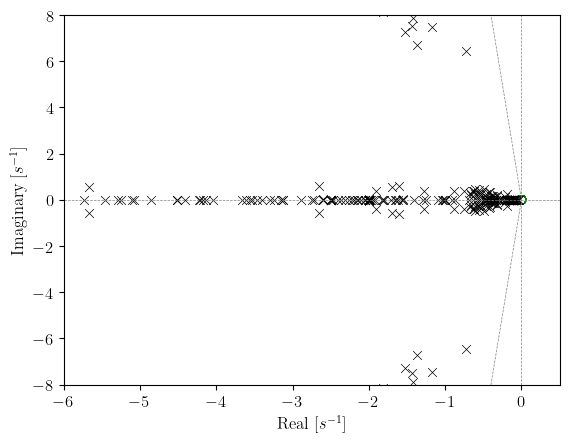

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Real [$s^{-1}$]', ylabel='Imaginary [$s^{-1}$]'>)

In [18]:
sa.EIG.run()
sa.EIG.plot()

In [19]:
sa.TDS.config.tf = 40
sa.TDS.config.criteria = 0
sa.TDS.config.no_tqdm = True

sa.TDS.run()


-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0.0-40 s.
Fixed step size: h=33.33 ms. Shrink if not converged.
Simulation to t=40.00 sec completed in 1.4821 seconds.


True

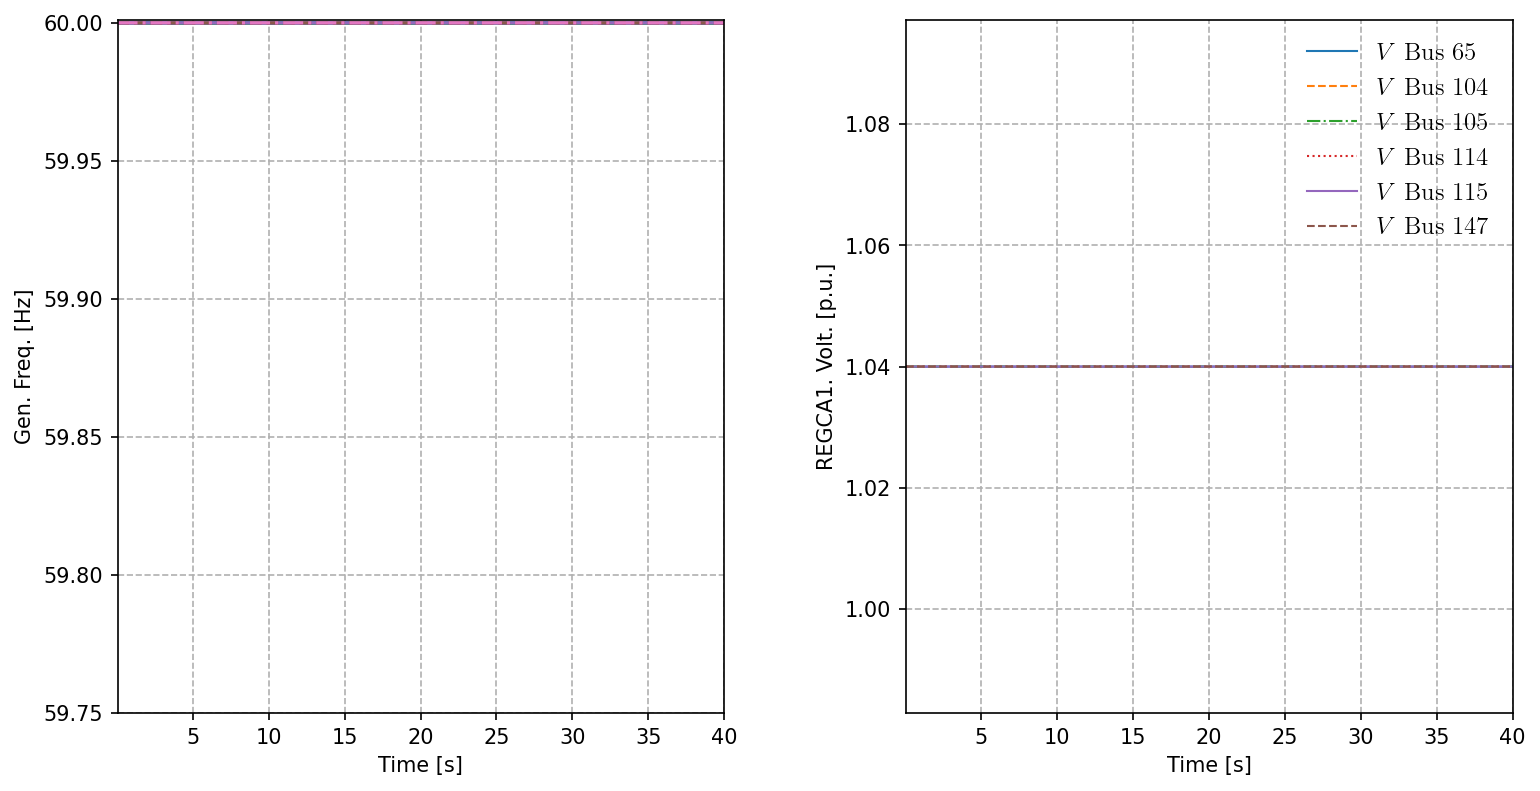

In [20]:
plt.style.use('default')
fig, ax = plt.subplots(1, 2, figsize=(12, 6), dpi=150)
plt.subplots_adjust(wspace=0.3)

_ = sa.TDS.plt.plot(sa.GENROU.omega,
                    line_width=1.5,
                    ymin=59.75, ymax=60.001,
                    ytimes=sa.config.freq,
                    show=False, grid=True,
                    ylabel='Gen. Freq. [Hz]',
                    fig=fig, ax=ax[0],)
_ = sa.TDS.plt.plot(sa.REGCA1.v,
                    show=False, grid=True,
                    ylabel='REGCA1. Volt. [p.u.]',
                    fig=fig, ax=ax[1],)